In [1]:
from pyNN.random import RandomDistribution, NumpyRNG
from pyNN import neuron
import pyNN.space as space
import pyNN
import pyNN.neuron as sim
import numpy as np
from pyNN.utility.plotting import Figure, Panel
from pyNN.space import Grid2D, RandomStructure, Sphere
import matplotlib.pyplot as plt
from neuroml import Morphology, Segment, Point3DWithDiam as P
from pyNN.morphology import NeuroMLMorphology, NeuriteDistribution, Morphology as Morph, IonChannelDistribution
from pyNN.neuron.morphology import uniform, random_section, random_placement, at_distances, apical_dendrites, dendrites, centre
from pyNN.parameters import IonicSpecies
from pyNN.standardmodels import StandardIonChannelModel, build_translations
from pyNN.neuron import NativeCellType
import shutil
import os
from neuron import h, nrn, hclass
from pyNN.utility.build import compile_nmodl
from pyNN.standardmodels.cells import MultiCompartmentNeuron as mc
import platform

numprocs=1
100 NetStimFD() neuron.hclass3
100 PoissonStimRefractory() neuron.hclass3
100 GammaStim() neuron.hclass3
100 VecStim() neuron.hclass3


In [2]:
if platform.system() == 'Linux':
    shutil.copyfile('mn.mod','modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.mod')
    compile_nmodl('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/')
    h.nrn_load_dll('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.o')
if platform.system() == 'Windows':
    shutil.copyfile('mn.mod','modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.mod')
    compile_nmodl('modelpynn/Lib/site-packages/pyNN/neuron/nmodl')
    h.nrn_load_dll('modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.o')


nrnivmodl found at /media/rnwatanabe/Data/Renato/Modelo-Motoneuronio/modelpynn/bin/nrnivmodl
Successfully compiled NEURON extensions.


In [3]:
# input_rate = 100
# refractory_period = RandomDistribution('uniform', [2.0, 3.0], rng=NumpyRNG(seed=4242))
# v_init = RandomDistribution('uniform', (-70.0, -60.0))
# ctx_parameters = {
#     'cm': 0.25, 'tau_m': 20.0, 'v_rest': -60, 'v_thresh': -50, 'tau_refrac': refractory_period,
#     'v_reset': -60, 'v_spike': -50.0, 'a': 1.0, 'b': 0.005, 'tau_w': 600, 'delta_T': 2.5,
#     'tau_syn_E': 5.0, 'e_rev_E': 0.0, 'tau_syn_I': 10.0, 'e_rev_I': -80 }
# cortical_type = sim.EIF_cond_exp_isfa_ista(**ctx_parameters)

In [4]:
class KsChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    translations = build_translations(
        ('conductance_density', 'gk_slow'),
        ('e_rev', 'eks'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'p': ('motoneuron', 'p'),
    }
    default_initial_values = {
        'p': 1,  # initial value for gating variable m
    }
    units = {
        'iks': 'mA/cm2',
        'p': 'dimensionless',
    }
    recordable = ['iks','p']
    model = "motoneuron"
    conductance_density_parameter = 'gk_slow'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [5]:
class KfChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    recordable = ['ikf','n'] 
    translations = build_translations(
        ('conductance_density', 'gk_fast'),
        ('e_rev', 'ekf'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'n': ('motoneuron', 'n'),
    }
    default_initial_values = {
        'n': 1,  # initial value for gating variable m
    }
    units = {
        'ikf': 'mA/cm2',
        'n': 'dimensionless',
    }
    model = "motoneuron"
    conductance_density_parameter = 'gk_fast'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [6]:
class NaChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": 50,
        "vt":-57.65,
    }
    
    default_initial_values = {
        'm': 1.0,  # initial value for gating variable m
        'h': 0.0,  # initial value for gating variable h
    }
    recordable = ['ina', 'm', 'h']
    units = {
        'ina': 'mA/cm2',
        'm': 'dimensionless',
        'h': 'dimensionless',
    }
    translations = build_translations(
        ('conductance_density', 'gna'),
        ('e_rev', 'ena'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'h': ('motoneuron', 'h'),
        'm': ('motoneuron', 'm'),
        'ina': ('motoneuron', 'ina'),
    }
    model = "motoneuron"
    conductance_density_parameter = 'gna'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [7]:
class PassiveLeak(StandardIonChannelModel):
    translations = build_translations(
        ('conductance_density', 'gl'),
        ('e_rev', 'el'),
    )
    variable_translations = {}
    model = "motoneuron"
    conductance_density_parameter = 'gl'

In [8]:
soma1 = Segment(proximal=P(x=77.5, y=0, z=0, diameter=77.5),
               distal=P(x=0, y=0, z=0, diameter=77.5),
               name="soma", id=0)
soma2 = Segment(proximal=P(x=82.5, y=0, z=0, diameter=82.5),
               distal=P(x=0, y=0, z=0, diameter=82.5),
               name="soma", id=0)
dend1 = Segment(proximal=P(x=0, y=18, z=0, diameter=41.5),
               distal=P(x=-5500, y=18, z=0, diameter=41.5),
               name="dendrite",
               parent=soma1, id=1)
dend2 = Segment(proximal=P(x=0, y=0, z=0, diameter=62.5),
               distal=P(x=-6789, y=0, z=0, diameter=62.5),
               name="dendrite",
               parent=soma2, id=1)

class cell_class(sim.MultiCompartmentNeuron):


    def __init__(self, **parameters):

        self.label = "mn1"
        self.ion_channels = {'pas_soma': PassiveLeak, 'pas_dend': sim.PassiveLeak,
                           'na': NaChannel, 'kf': KfChannel, 'ks': KsChannel}
        self.units = {'v':'mV',
                      'gsyn_exc': 'uS',
                      'gsyn_inh': 'uS',
                      'na.m': 'dimensionless', 'na.h': 'dimensionless', 'kf.n': 'dimensionless', 'ks.p': 'dimensionless',
                      'na.ina': 'mA/cm2', 'kf.ikf': 'mA/cm2', 'ks.iks': 'mA/cm2'}
        self.post_synaptic_entities = {'syn': sim.CondExpPostSynapticResponse}
        
        super(cell_class, self).__init__(**parameters)
    
   


In [9]:
cell_type = cell_class(
    morphology=[NeuroMLMorphology(Morphology(segments=(soma1, 
                                                       dend1))),
                NeuroMLMorphology(Morphology(segments=(soma2, 
                                                       dend2)))],
    cm=1,    # mF / cm**2
    Ra=0.070, # ohm.mm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 10), "vt":[-57.65, -53]},
    kf = {"conductance_density": uniform('soma', 1), "vt":[-57.65, -53]},
    ks = {"conductance_density": uniform('soma', 0.5), "vt":[-57.65, -53]},

    syn={
        "locations": centre('dendrite'),
        "e_syn": 0,
        "tau_syn": 0.6},  
)

In [10]:
cells = sim.Population(2, cell_type, initial_values={'v': [-70, -70]})

In [11]:
cells[0]._cell.synaptic_receptors

{'syn': defaultdict(list, {1: [ExpSyn[0]]})}

In [12]:
def generate_spike_times(i):
    input_rate = 83
    Tf = 100
    number = int(Tf * input_rate / 1000.0)
    gen = lambda: sim.Sequence(np.add.accumulate(np.random.exponential(1000.0 / input_rate, size=number)))
    if hasattr(i, "__len__"):
        return [gen() for j in i]
    else:
        return gen()


In [13]:
np.random.seed(26278342)
spike_source = sim.Population(400, sim.SpikeSourceArray(spike_times=generate_spike_times))
# spike_source.rate=83
syn = sim.StaticSynapse(weight=0.6, delay=0.2)
input_conns = sim.Projection(spike_source, cells, 
                             sim.FixedProbabilityConnector(0.3, location_selector='dendrite'), 
                             syn, receptor_type="syn")

Sequence([ 6.14274767  6.39770884 13.49498912 26.13101463 63.51706517 81.62395936
 95.05172013 95.36591886])
Sequence([41.5055847  54.44834289 55.75468639 60.30605242 61.7432445  69.08535229
 94.45468682 96.46117869])
Sequence([  5.97248405  19.13264168  65.21302633  66.24408991  86.53431529
  93.39131067  96.38978891 114.47828465])
Sequence([  1.97005362  30.39864407  55.59764861  59.11640187  71.30499268
 106.38625134 107.90142565 110.7183651 ])
Sequence([ 0.17038175  5.46209456 23.34987196 42.52050812 48.90502785 51.14512159
 64.14862505 69.18165634])
Sequence([ 0.93022671 36.01159565 42.68960113 54.01421249 56.45758664 65.09524143
 77.09353865 93.22208708])
Sequence([ 4.52987916 11.34046786 14.33923285 18.49726296 48.51023866 63.77522449
 64.54543971 75.1468811 ])
Sequence([ 3.38836087  6.71839996 17.40326816 24.0870286  33.9167293  47.91887575
 53.23647582 69.00635394])
Sequence([ 9.40922796 18.03034894 20.8603608  51.0022808  59.2530253  60.28485443
 60.84482038 61.13999811])
Seq

In [14]:
step_current_dend = sim.DCSource(amplitude=7000, start=0, stop=50)
#step_current.inject_into(cells[1:2], location=apical_dendrites(fraction_along=0.9))
#step_current.inject_into(cells[1:2], location=random(after_branch_point(3)(apical_dendrites))
# step_current_dend.inject_into(cells[0:2], location='dendrite')

In [15]:
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')


In [16]:
sim.run(10)

t 0.0


9.999999999999966

element(): index=2, etime=1.01963, t=0.00861267
element(): index=2, etime=20.792, t=0.0386449
element(): index=2, etime=5.46851, t=0.0534965
element(): index=2, etime=4.62731, t=0.0746008
element(): index=2, etime=19.5641, t=0.141256
element(): index=2, etime=1.69659, t=0.169687
element(): index=2, etime=5.46209, t=0.170382
element(): index=2, etime=10.2602, t=0.178093
element(): index=2, etime=15.8678, t=0.182079
element(): index=2, etime=8.11872, t=0.241159
element(): index=2, etime=15.0838, t=0.273393
element(): index=2, etime=6.04152, t=0.284464
element(): index=2, etime=16.5027, t=0.318331
element(): index=2, etime=0.771272, t=0.335561
element(): index=2, etime=19.2295, t=0.338719
element(): index=2, etime=9.87225, t=0.353568
element(): index=2, etime=16.7406, t=0.385089
element(): index=2, etime=16.7358, t=0.399012
element(): index=2, etime=5.58991, t=0.404506
element(): index=2, etime=15.3838, t=0.406695
element(): index=2, etime=1.48425, t=0.415183
element(): index=2, etime=6.1

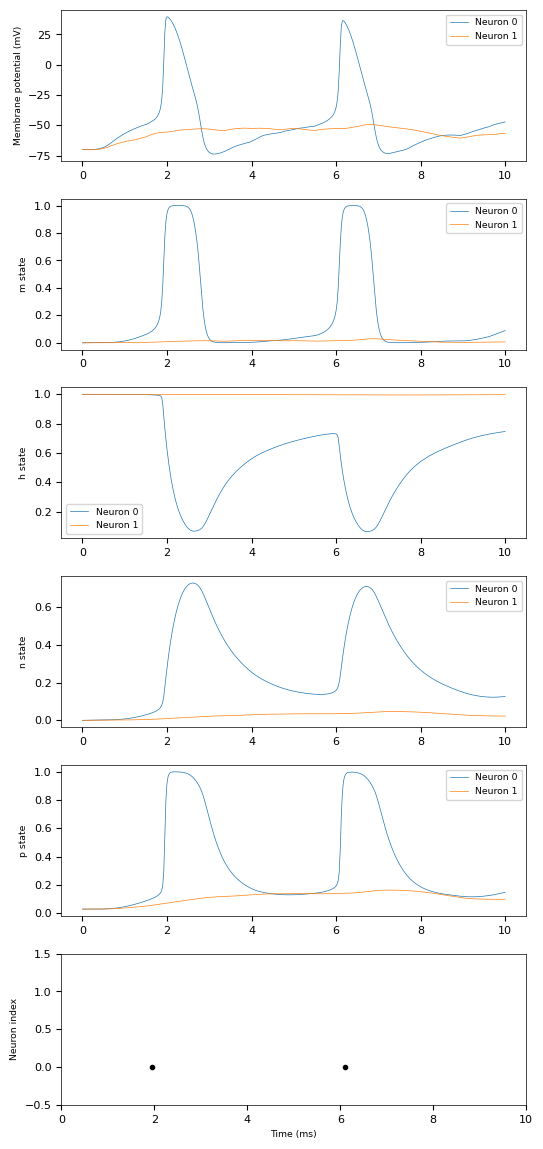

In [17]:
figure_filename = 'teste.png'

data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),
    
    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)
